In [ ]:
!pip install torchmetrics
!pip install timm
import os
import torch
import torchmetrics
import timm
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from google.colab import drive
from PIL import Image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 854.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Định nghĩa lớp (classes)
classes = ['normal', 'osteopenia', 'osteoporosis']

# Tiền xử lý ảnh X-ray
def preprocess_xray(image):
    image = image.convert('RGB')  # Đảm bảo 3 kênh
    image = transforms.functional.adjust_contrast(image, contrast_factor=2.0)  # Tăng contrast
    return image

# Data augmentation và transform
train_transforms = transforms.Compose([
    preprocess_xray,
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    preprocess_xray,
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dataset
from torchvision.datasets import ImageFolder
train_dataset = ImageFolder('/content/drive/MyDrive/data/train/', transform=train_transforms)
val_dataset = ImageFolder('/content/drive/MyDrive/data/valid/', transform=val_transforms)

# DataLoader
tr_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Kiểm tra dữ liệu
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
sample_batch = next(iter(tr_dl))
print(f"Sample batch shape (images, labels): {sample_batch[0].shape}, {sample_batch[1].shape}")

Train samples: 3780
Validation samples: 1080
Sample batch shape (images, labels): torch.Size([32, 3, 224, 224]), torch.Size([32])


In [ ]:
class TrainValidation:
    def __init__(self, model_name, classes, tr_dl, val_dl, device, save_dir="saved_models",
                 save_prefix="model", lr=3e-4, epochs=50, patience=5, threshold=0.01,
                 dev_mode=False):
        self.model_name = model_name
        self.classes = classes
        self.tr_dl = tr_dl
        self.val_dl = val_dl
        self.save_dir = save_dir
        self.save_prefix = save_prefix
        self.lr = lr
        self.epochs = epochs
        self.patience = patience
        self.threshold = threshold
        self.dev_mode = dev_mode
        self.device = device
        self.model = timm.create_model(model_name, pretrained=True, num_classes=len(classes)).to(self.device)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(self.device)

        os.makedirs(save_dir, exist_ok=True)

        self.best_loss = float("inf")
        self.best_acc = 0
        self.not_improved = 0

        self.tr_losses, self.val_losses = [], []
        self.tr_accs, self.val_accs = [], []
        self.tr_f1s, self.val_f1s = [], []

    @staticmethod
    def to_device(batch, device):
        ims, gts = batch
        return ims.to(device), gts.to(device)

    def train_epoch(self):
        self.model.train()
        train_loss, train_acc = 0.0, 0.0
        self.f1_metric.reset()

        for idx, batch in tqdm(enumerate(self.tr_dl), desc="Training"):
            if self.dev_mode and idx == 1: break
            try:
                ims, gts = TrainValidation.to_device(batch, device=self.device)
                preds = self.model(ims)
                loss = self.loss_fn(preds, gts)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                train_acc += (torch.argmax(preds, dim=1) == gts).sum().item()
                self.f1_metric.update(preds, gts)
            except Exception as e:
                print(f"Error in training batch {idx}: {e}")
                break

        train_loss /= len(self.tr_dl)
        train_acc /= len(self.tr_dl.dataset)
        train_f1 = self.f1_metric.compute().item()

        self.tr_losses.append(train_loss)
        self.tr_accs.append(train_acc)
        self.tr_f1s.append(train_f1)

        return train_loss, train_acc, train_f1

    def validate_epoch(self):
        self.model.eval()
        val_loss, val_acc = 0.0, 0.0
        self.f1_metric.reset()

        with torch.no_grad():
            for idx, batch in tqdm(enumerate(self.val_dl), desc="Validation"):
                if self.dev_mode and idx == 1: break
                try:
                    ims, gts = TrainValidation.to_device(batch, device=self.device)
                    preds = self.model(ims)
                    loss = self.loss_fn(preds, gts)
                    val_loss += loss.item()
                    val_acc += (torch.argmax(preds, dim=1) == gts).sum().item()
                    self.f1_metric.update(preds, gts)
                except Exception as e:
                    print(f"Error in validation batch {idx}: {e}")
                    break

        val_loss /= len(self.val_dl)
        val_acc /= len(self.val_dl.dataset)
        val_f1 = self.f1_metric.compute().item()

        self.val_losses.append(val_loss)
        self.val_accs.append(val_acc)
        self.val_f1s.append(val_f1)

        return val_loss, val_acc, val_f1

    def fine_tune(self, lr_fine=5e-4, stages_to_unfreeze=4):
        print("Starting fine-tuning...")
        for param in self.model.parameters():
            param.requires_grad = False
        # rexnet_150 có submodule 'features' chứa các stage
        # Mở khóa stages_to_unfreeze stage cuối của features
        for param in self.model.get_submodule("features")[-stages_to_unfreeze:].parameters():
            param.requires_grad = True
        self.optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=lr_fine)

    def save_best_model(self, val_f1, val_loss):
        if val_f1 > self.best_acc + self.threshold:
            self.best_acc = val_f1
            save_path = os.path.join(self.save_dir, f"{self.save_prefix}_best_model.pth")
            torch.save(self.model.state_dict(), save_path)
            print(f"Best model saved with F1-Score: {self.best_acc:.3f}")
            self.not_improved = 0
        else:
            self.not_improved += 1
            print(f"No improvement for {self.not_improved} epoch(s).")

    def save_final_model(self):
        save_path = os.path.join(self.save_dir, f"{self.save_prefix}_final_model.pth")
        torch.save(self.model.state_dict(), save_path)
        print(f"Final model saved at: {save_path}")

    def verbose(self, epoch, metric1, metric2, metric3, process="train"):
        print(f"{epoch + 1}-epoch {process} process is completed!\n")
        print(f"{epoch + 1}-epoch {process} loss          -> {metric1:.3f}")
        print(f"{epoch + 1}-epoch {process} accuracy      -> {metric2:.3f}")
        print(f"{epoch + 1}-epoch {process} f1-score      -> {metric3:.3f}\n")

    def run(self):
        print("Start training...")
        for epoch in range(self.epochs):
            if self.dev_mode and epoch == 1: break
            print(f"\nEpoch {epoch + 1}/{self.epochs}:\n")

            train_loss, train_acc, train_f1 = self.train_epoch()
            self.verbose(epoch, train_loss, train_acc, train_f1, process="train")

            val_loss, val_acc, val_f1 = self.validate_epoch()
            self.verbose(epoch, val_loss, val_acc, val_f1, process="validation")

            self.save_best_model(val_f1, val_loss)

            if self.not_improved >= self.patience:
                print("Early stopping triggered.")
                break

            # Fine-tuning sau 20 epoch nếu chưa dừng
            if epoch == 19 and self.not_improved < self.patience:
                self.fine_tune(lr_fine=5e-4, stages_to_unfreeze=4)

        # Lưu model cuối cùng sau khi huấn luyện
        self.save_final_model()

In [ ]:
# Thiết lập tham số
model_name = "rexnet_150"
save_prefix = "knee"
save_dir = "saved_models"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Khởi tạo trainer
trainer = TrainValidation(model_name=model_name, device=device,
                          save_prefix=save_prefix, classes=classes,
                          patience=5, tr_dl=tr_dl, val_dl=val_dl, dev_mode=False)

# Chạy huấn luyện
trainer.run()

Start training...

Epoch 1/50:



Training: 119it [00:31,  3.73it/s]

1-epoch train process is completed!

1-epoch train loss          -> 1.438
1-epoch train accuracy      -> 0.588
1-epoch train f1-score      -> 0.588




Validation: 34it [00:04,  7.52it/s]


1-epoch validation process is completed!

1-epoch validation loss          -> 1.068
1-epoch validation accuracy      -> 0.592
1-epoch validation f1-score      -> 0.592

Best model saved with F1-Score: 0.592

Epoch 2/50:



Training: 119it [00:30,  3.86it/s]

2-epoch train process is completed!

2-epoch train loss          -> 0.924
2-epoch train accuracy      -> 0.644
2-epoch train f1-score      -> 0.644




Validation: 34it [00:05,  5.75it/s]


2-epoch validation process is completed!

2-epoch validation loss          -> 0.881
2-epoch validation accuracy      -> 0.636
2-epoch validation f1-score      -> 0.636

Best model saved with F1-Score: 0.636

Epoch 3/50:



Training: 119it [00:29,  3.97it/s]

3-epoch train process is completed!

3-epoch train loss          -> 0.745
3-epoch train accuracy      -> 0.698
3-epoch train f1-score      -> 0.698




Validation: 34it [00:04,  7.48it/s]


3-epoch validation process is completed!

3-epoch validation loss          -> 0.728
3-epoch validation accuracy      -> 0.679
3-epoch validation f1-score      -> 0.679

Best model saved with F1-Score: 0.679

Epoch 4/50:



Training: 119it [00:31,  3.83it/s]

4-epoch train process is completed!

4-epoch train loss          -> 0.655
4-epoch train accuracy      -> 0.719
4-epoch train f1-score      -> 0.719




Validation: 34it [00:06,  5.54it/s]

4-epoch validation process is completed!

4-epoch validation loss          -> 0.785
4-epoch validation accuracy      -> 0.677
4-epoch validation f1-score      -> 0.677

No improvement for 1 epoch(s).

Epoch 5/50:




Training: 119it [00:30,  3.91it/s]

5-epoch train process is completed!

5-epoch train loss          -> 0.574
5-epoch train accuracy      -> 0.761
5-epoch train f1-score      -> 0.761




Validation: 34it [00:05,  5.89it/s]


5-epoch validation process is completed!

5-epoch validation loss          -> 0.714
5-epoch validation accuracy      -> 0.707
5-epoch validation f1-score      -> 0.707

Best model saved with F1-Score: 0.707

Epoch 6/50:



Training: 119it [00:30,  3.95it/s]

6-epoch train process is completed!

6-epoch train loss          -> 0.532
6-epoch train accuracy      -> 0.780
6-epoch train f1-score      -> 0.780




Validation: 34it [00:04,  7.65it/s]


6-epoch validation process is completed!

6-epoch validation loss          -> 0.639
6-epoch validation accuracy      -> 0.731
6-epoch validation f1-score      -> 0.731

Best model saved with F1-Score: 0.731

Epoch 7/50:



Training: 119it [00:30,  3.91it/s]

7-epoch train process is completed!

7-epoch train loss          -> 0.483
7-epoch train accuracy      -> 0.803
7-epoch train f1-score      -> 0.803




Validation: 34it [00:05,  6.29it/s]


7-epoch validation process is completed!

7-epoch validation loss          -> 0.554
7-epoch validation accuracy      -> 0.767
7-epoch validation f1-score      -> 0.767

Best model saved with F1-Score: 0.767

Epoch 8/50:



Training: 119it [00:30,  3.95it/s]

8-epoch train process is completed!

8-epoch train loss          -> 0.419
8-epoch train accuracy      -> 0.825
8-epoch train f1-score      -> 0.825




Validation: 34it [00:04,  7.04it/s]


8-epoch validation process is completed!

8-epoch validation loss          -> 0.528
8-epoch validation accuracy      -> 0.803
8-epoch validation f1-score      -> 0.803

Best model saved with F1-Score: 0.803

Epoch 9/50:



Training: 119it [00:31,  3.80it/s]

9-epoch train process is completed!

9-epoch train loss          -> 0.398
9-epoch train accuracy      -> 0.837
9-epoch train f1-score      -> 0.837




Validation: 34it [00:04,  7.60it/s]

9-epoch validation process is completed!

9-epoch validation loss          -> 0.601
9-epoch validation accuracy      -> 0.763
9-epoch validation f1-score      -> 0.763

No improvement for 1 epoch(s).

Epoch 10/50:




Training: 119it [00:30,  3.92it/s]

10-epoch train process is completed!

10-epoch train loss          -> 0.379
10-epoch train accuracy      -> 0.842
10-epoch train f1-score      -> 0.842




Validation: 34it [00:05,  5.82it/s]

10-epoch validation process is completed!

10-epoch validation loss          -> 0.587
10-epoch validation accuracy      -> 0.758
10-epoch validation f1-score      -> 0.758

No improvement for 2 epoch(s).

Epoch 11/50:




Training: 119it [00:30,  3.93it/s]

11-epoch train process is completed!

11-epoch train loss          -> 0.350
11-epoch train accuracy      -> 0.852
11-epoch train f1-score      -> 0.852




Validation: 34it [00:04,  7.08it/s]

11-epoch validation process is completed!

11-epoch validation loss          -> 0.471
11-epoch validation accuracy      -> 0.810
11-epoch validation f1-score      -> 0.810

No improvement for 3 epoch(s).

Epoch 12/50:




Training: 119it [00:30,  3.91it/s]

12-epoch train process is completed!

12-epoch train loss          -> 0.346
12-epoch train accuracy      -> 0.857
12-epoch train f1-score      -> 0.857




Validation: 34it [00:05,  6.46it/s]

12-epoch validation process is completed!

12-epoch validation loss          -> 0.504
12-epoch validation accuracy      -> 0.806
12-epoch validation f1-score      -> 0.806

No improvement for 4 epoch(s).

Epoch 13/50:




Training: 119it [00:30,  3.84it/s]

13-epoch train process is completed!

13-epoch train loss          -> 0.338
13-epoch train accuracy      -> 0.863
13-epoch train f1-score      -> 0.863




Validation: 34it [00:04,  7.36it/s]


13-epoch validation process is completed!

13-epoch validation loss          -> 0.477
13-epoch validation accuracy      -> 0.806
13-epoch validation f1-score      -> 0.806

No improvement for 5 epoch(s).
Early stopping triggered.
Final model saved at: saved_models/knee_final_model.pth


Number of epochs trained: 13
Train Losses: [1.438251939140448, 0.9239192827909934, 0.7452759449722386, 0.6547232082411021, 0.5737722626253337, 0.5323901461953876, 0.4834895411960217, 0.418789658977204, 0.3977762944057208, 0.37888793916511937, 0.34994058317246557, 0.3458035978324273, 0.33759434890596807]
Validation Losses: [1.0676602300475626, 0.8812998989049126, 0.7284178335000487, 0.7849603488164789, 0.7144819686517996, 0.6388490285505267, 0.5538580084548277, 0.527898396639263, 0.6008601196329383, 0.5869099377271008, 0.47137326593784723, 0.5035808361409342, 0.4766116718597272]
Train Accuracies: [0.5878306878306878, 0.6439153439153439, 0.6984126984126984, 0.7193121693121693, 0.7605820105820106, 0.7801587301587302, 0.8031746031746032, 0.8253968253968254, 0.8367724867724867, 0.8415343915343916, 0.8523809523809524, 0.8566137566137566, 0.8632275132275132]
Validation Accuracies: [0.5916666666666667, 0.6361111111111111, 0.6787037037037037, 0.6768518518518518, 0.7074074074074074, 0.7305555555

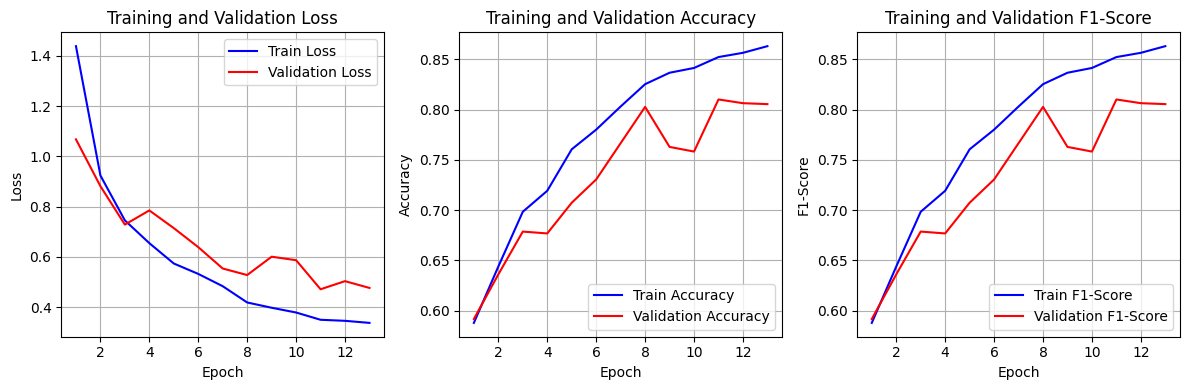

In [ ]:
import matplotlib.pyplot as plt

# Giả sử trainer đã được khởi tạo và run trước đó
# Kiểm tra dữ liệu đã lưu
print(f"Number of epochs trained: {len(trainer.tr_losses)}")
print(f"Train Losses: {trainer.tr_losses}")
print(f"Validation Losses: {trainer.val_losses}")
print(f"Train Accuracies: {trainer.tr_accs}")
print(f"Validation Accuracies: {trainer.val_accs}")
print(f"Train F1-Scores: {trainer.tr_f1s}")
print(f"Validation F1-Scores: {trainer.val_f1s}")

# Vẽ đồ thị
epochs = range(1, len(trainer.tr_losses) + 1)

# Vẽ Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, trainer.tr_losses, 'b-', label='Train Loss')
plt.plot(epochs, trainer.val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Vẽ Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, trainer.tr_accs, 'b-', label='Train Accuracy')
plt.plot(epochs, trainer.val_accs, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Vẽ F1-Score
plt.subplot(1, 3, 3)
plt.plot(epochs, trainer.tr_f1s, 'b-', label='Train F1-Score')
plt.plot(epochs, trainer.val_f1s, 'r-', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import os
save_dir = "saved_models"  # Hoặc "/content/drive/MyDrive/saved_models" nếu lưu vào Drive
print(f"Directory exists: {os.path.exists(save_dir)}")
if os.path.exists(save_dir):
    print(f"Files in {save_dir}: {os.listdir(save_dir)}")
else:
    print(f"Directory {save_dir} not found. Check if it was saved to Google Drive or reset runtime.")

Directory exists: True
Files in saved_models: ['knee_best_model.pth', 'knee_final_model.pth']


In [ ]:
import os
import shutil

# Kiểm tra file trong /content/saved_models
save_dir = "saved_models"
print(f"Files in {save_dir}: {os.listdir(save_dir)}")

# Di chuyển thư mục sang Google Drive
new_save_dir = "/content/drive/MyDrive/saved_models"
os.makedirs(new_save_dir, exist_ok=True)
shutil.move(save_dir, new_save_dir)
print(f"Moved {save_dir} to {new_save_dir}")

Files in saved_models: ['knee_best_model.pth', 'knee_final_model.pth']
Moved saved_models to /content/drive/MyDrive/saved_models
